# Enviornment

In [7]:
!ls ../../data

# Import

In [100]:
import os
import math
import glob

from box import Box
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedKFold

# Constant

In [69]:
cfg = {
    'SAVE_DIR': '../../data',
    'SEED': 1234,
    'FOLDS': 7,
}
cfg = Box(cfg)

In [44]:
np.random.seed(cfg.SEED)

# Download data

In [43]:
X_org, y_org = fetch_openml('mnist_784', return_X_y=True)

/usr/local/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [45]:
# Reshape table value into 2d array
X = X_org.values.reshape((-1, 28, 28))
y = y_org.values
print(f"X_org.shape: {X_org.shape}")
print(f"X.shape: {X.shape}")
print(f"y_org.shape: {y_org.shape}")
print(f"y.shape: {y.shape}")

X_org.shape: (70000, 784)
X.shape: (70000, 28, 28)
y_org.shape: (70000,)
y.shape: (70000,)


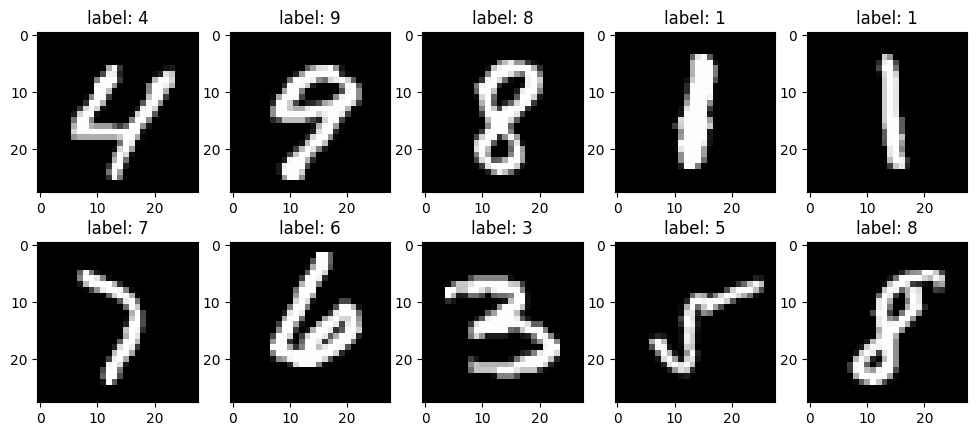

In [49]:
# Display few images
num_sample = 10
sample_idxs = np.random.choice(range(len(X)), size=num_sample, replace=False)
n_cols = 5
n_rows = math.ceil(num_sample / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5))
axes = axes.ravel()
for i, sample_idx in enumerate(sample_idxs):
    axes[i].imshow(X[sample_idx], cmap='gray')
    axes[i].set_title(f'label: {y[sample_idx]}')

# Save data

**Structure is as follows**
- data
    - mnist
        - [label]
            - [number in 5 digits starting from 00000].jpg
    - folds
        - [number in 3 digits starting from 000]
            - fold.csv

## Images

In [63]:
# Directory for saving training data
mnist_dir = os.path.join(cfg.SAVE_DIR, 'mnist')
os.makedirs(mnist_dir, exist_ok=True)

In [54]:
# Directory for images
labels = np.unique(y)
labels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [66]:
labels = np.unique(y)
for label in labels:
    # Directory for images
    img_dir = os.path.join(mnist_dir, label)
    os.makedirs(img_dir, exist_ok=True)
    # Search index with certain label
    img_idxs = np.where(y == label)[0]
    imgs = X[img_idxs]
    for i, img in enumerate(imgs):
        img_path = os.path.join(img_dir, str(i).zfill(5)) + '.jpg'
        cv2.imwrite(img_path, img)

## Folds

In [105]:
# Directory for saving fold definition
fold_dir = os.path.join(cfg.SAVE_DIR, 'fold', '000')
os.makedirs(fold_dir, exist_ok=True)

In [91]:
# Read file paths
data_paths = np.array(glob.glob(os.path.join(mnist_dir, '*', '*.jpg')))
labels = [int(path.split('/')[-2]) for path in data_paths]

In [99]:
# Split data into folds
folds = []
paths = []
k_fold = StratifiedKFold(n_splits=cfg.FOLDS, shuffle=True, random_state=cfg.SEED)
for fold_i, (_, valid_idx) in enumerate(k_fold.split(X=data_paths, y=labels)):
    folds += [fold_i] * len(valid_idx)
    paths += list(data_paths[valid_idx])

In [104]:
# Convert to pandas DataFrmae
fold_def = pd.DataFrame({'fold_idx': folds,'path': paths})
print(f'fold_def.shape: {fold_def.shape}')
fold_def.head()

fold_def.shape: (70000, 2)


,fold_idx,path
0,0,../../data/mnist/5/06248.jpg
1,0,../../data/mnist/5/00437.jpg
2,0,../../data/mnist/5/05458.jpg
3,0,../../data/mnist/5/05145.jpg
4,0,../../data/mnist/5/03274.jpg


In [106]:
# Save fold definition in csv
fold_path = os.path.join(fold_dir, 'stratified_fold.csv')
fold_def.to_csv(fold_path, index=False)